In this notebook, the data for Figure 7 is generated.<br>
This is for two ferromagnetic materials joined together, with the DMI being on the top, bottom or both interfaces. We consider only DMI on the top and bottom of a Ir/Fe/Co/Pt stack.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eig
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import StrMethodFormatter
from scipy.optimize import curve_fit
import sympy as sp
from sympy import expand, symbols

In [2]:
def MatrixM(H,A,Ms,a,gamma,laynum,D,k):
    A1,A2,A12=A
    gamma1,gamma2=gamma
    a1,a2=a
    M_s1,M_s2=Ms
    N1,N2=laynum
    D1,D2=D
    kx,kz=k
    SW=np.zeros((2*(N1+N2),2*(N1+N2)),dtype=np.complex128)
    nn=np.linspace(0,N1+N2-1,N1+N2)
    mu_0=4*np.pi*1e-7
    a_ave=(a1+a2)/2
    B_zee=mu_0*H
    B_dem1=mu_0*M_s1
    B_dem2=mu_0*M_s2
    B_DM1=2*D1/(a1*M_s1)
    B_DM2=2*D2/(a2*M_s2)
    B_ex1=2*A1/((a1**2)*M_s1)
    B_ex2=2*A2/((a2**2)*M_s2)
    B_ex12_1=2*A12/((a_ave**2)*M_s1)
    B_ex12_2=2*A12/((a_ave**2)*M_s2)
    k_ex1=2*( np.cos(a1*kx)+np.cos(a1*kz) )
    k_ex2=2*( np.cos(a2*kx)+np.cos(a2*kz) )
    k_DM1=np.sin(a1*kx)
    k_DM2=-np.sin(a2*kx)
    iG1=-1j*gamma1
    iG2=-1j*gamma2
    for nn in range(0,1):
        SW[0][0]=(1j*B_DM1*k_DM1)*iG1
        SW[0][1]=(B_zee+B_ex1*(5-k_ex1)+B_dem1)*iG1
        SW[0][3]=(-B_ex1)*iG1
        SW[1][0]=( -(B_zee+B_ex1*(5-k_ex1)) )*iG1
        SW[1][1]=( 1j*B_DM1*k_DM1 )*iG1
        SW[1][2]=B_ex1*iG1
        for nn in range(1,N1-1): 
            SW[2*nn][2*(nn-1)+1]=(-B_ex1)*iG1 
            SW[2*nn][2*nn+1]=(B_zee+B_ex1*(6-k_ex1)+B_dem1)*iG1 
            SW[2*nn][2*(nn+1)+1]=(-B_ex1)*iG1 
            SW[2*nn+1][2*(nn-1)]=B_ex1*iG1 
            SW[2*nn+1][2*nn]=( -(B_zee+B_ex1*(6-k_ex1)) )*iG1 
            SW[2*nn+1][2*(nn+1)]=B_ex1*iG1
            for nn in range(N1-1,N1):
                SW[2*nn][2*(nn-1)+1]=(-B_ex1)*iG1 
                SW[2*nn][2*nn+1]=(B_zee+B_ex1*(5-k_ex1)+B_dem1+B_ex12_1)*iG1 
                SW[2*nn][2*(nn+1)+1]=(-B_ex12_1)*iG1 
                SW[2*nn+1][2*(nn-1)]=B_ex1*iG1 
                SW[2*nn+1][2*nn]=(-(B_zee+B_ex1*(5-k_ex1)+B_ex12_1))*iG1 
                SW[2*nn+1][2*(nn+1)]=B_ex12_1*iG1
                for nn in range(N1,N1+1):
                    SW[2*nn][2*(nn-1)+1]=(-B_ex12_2)*iG2 
                    SW[2*nn][2*nn+1]=(B_zee+B_ex2*(5-k_ex2)+B_dem2+B_ex12_2)*iG2 
                    SW[2*nn][2*(nn+1)+1]=(-B_ex2)*iG2 
                    SW[2*nn+1][2*(nn-1)]=B_ex12_2*iG2 
                    SW[2*nn+1][2*nn]=(-(B_zee+B_ex2*(5-k_ex2)+B_ex12_2))*iG2 
                    SW[2*nn+1][2*(nn+1)]=B_ex2*iG2
                    for nn in range(N1+1,N1+N2-1):
                        SW[2*nn][2*(nn-1)+1]=(-B_ex2)*iG2 
                        SW[2*nn][2*nn+1]=(B_zee+B_ex2*(6-k_ex2)+B_dem2)*iG2 
                        SW[2*nn][2*(nn+1)+1]=(-B_ex2)*iG2 
                        SW[2*nn+1][2*(nn-1)]=B_ex2*iG2 
                        SW[2*nn+1][2*nn]=( -(B_zee+B_ex2*(6-k_ex2)) )*iG2 
                        SW[2*nn+1][2*(nn+1)]=B_ex2*iG2
                        for nn in range(N1+N2-1,N1+N2):
                            SW[2*nn][2*(nn-1)+1]=(-B_ex2)*iG2
                            SW[2*nn][2*nn]=1j*B_DM2*k_DM2*iG2
                            SW[2*nn][2*nn+1]=(B_zee+B_ex2*(5-k_ex2)+B_dem2)*iG2 
                            SW[2*nn+1][2*(nn-1)]=B_ex2*iG2
                            SW[2*nn+1][2*nn]=( -(B_zee+B_ex2*(5-k_ex2)) )*iG2
                            SW[2*nn+1][2*nn+1]=1j*B_DM2*k_DM2*iG2
    return SW
# Frequency -----------------------------------------------------------------------------------
def FreqM(H,A,Ms,a,gamma,laynum,D,k,n):
    A1,A2,A12=A
    gamma1,gamma2=gamma
    a1,a2=a
    M_s1,M_s2=Ms
    N1,N2=laynum
    D1,D2=D
    kx,kz=k
    N1,N2=laynum
    SW=MatrixM(H,A,Ms,a,gamma,laynum,D,k)
    omegaGHz=[]                                     
    w,v=eig(SW)     
    omegaRaw = w         
    idx1 = np.argsort(omegaRaw)     
    omegaRaw = omegaRaw[idx1]     
    omega=np.zeros(N1+N2, dtype = 'complex_')    
    for ii in range (0,N1+N2):        
        omega[ii]=omegaRaw[ii+N1+N2]
        omegaGHz=omega/1e9
    return omegaGHz[n].real
# dispersion curve ----------------------------------------------------------------------------
def SWfreqkxM(H,A,Ms,a,gamma,laynum,D,MaxRe,n):
    A1,A2,A12=A
    gamma1,gamma2=gamma
    a1,a2=a
    M_s1,M_s2=Ms
    N1,N2=laynum
    D1,D2=D
    N1,N2=laynum
    Max,h=MaxRe
    omega1=np.zeros(int(2*Max/(h*1e6)+1))
    kx=np.linspace(-Max,Max, int(2*Max/(h*1e6)+1) )
    for ii in range (0, int(2*Max/(h*1e6)+1) ):
        omega1[ii]=FreqM(H,A,Ms,a,gamma,laynum,D,(kx[ii],0),n)                
    return omega1
def xSWfreqkxM(MaxRe):
    Max,h=MaxRe
    Max0=Max/1e6
    return np.linspace(-Max0,Max0,int(2*Max0/h+1))
# Get eiganvector of SW matrix to obtain the mode profile -------------------------------------------------------- 
def ModAmpXM(H,A,Ms,a,gamma,laynum,D,k,n):
    A1,A2,A12=A
    gamma1,gamma2=gamma
    a1,a2=a
    M_s1,M_s2=Ms
    N1,N2=laynum
    D1,D2=D
    kx,kz=k
    N1,N2=laynum
    SW=MatrixM(H,A,Ms,a,gamma,laynum,D,k)
    w,v=eig(SW) 
    omegaRaw=w 
    idx1 = np.argsort(omegaRaw) 
    omegaRaw = omegaRaw[idx1] 
    v = v[:,idx1] 
    EigV=np.zeros((2*(N1+N2),N1+N2),dtype = 'complex_')
    for ii in range (0,(N1+N2)): 
        for jj in range (0,2*(N1+N2)):                                  
            EigV[jj][ii]=v[jj][ii+(N1+N2)]
    EigVx=np.zeros(((N1+N2),(N1+N2)),dtype=np.complex128)
    for ii in range (0,(N1+N2)):
        for jj in range (0,(N1+N2)):
            EigVx[ii][jj]=EigV[2*ii][jj]
            if abs(EigVx[ii][jj].real)>abs(EigVx[ii][jj].imag): 
                EigVx[ii][jj]=EigVx[ii][jj].real
            else:
                EigVx[ii][jj]=EigVx[ii][jj].imag
    return EigVx[:,n].real
# layer number function --------------------------------------------------------
def xMobAmpM(laynum):
    N1,N2=laynum
    layers=np.linspace(1,(N1+N2),(N1+N2))
    return layers
# convert back to film thickness
def xMobthicknessM(a,laynum):
    a1,a2=a
    N1,N2=laynum
    layers=np.linspace(1,(N1+N2),(N1+N2))
    thickness=np.zeros(len(layers))
    for i in range (0,N1):
        thickness[i]=a1*layers[i]
        for i in range(N1,N1+N2):
            thickness[i]=a1*N1+(layers[i]-N1)*a2
    return thickness
def NModAmpXM(H,A,Ms,a,gamma,laynum,D,k,n):
    return ModAmpXM(H,A,Ms,a,gamma,laynum,D,k,n)/np.max( abs(ModAmpXM(H,A,Ms,a,gamma,laynum,D,k,n)) )

Here are the material parameters (written in the main text of the article too):

In [3]:
H_1=300*(1e3/(4*np.pi))  # A/m
D_1=(3.9e-3,-1.5e-3)    # J/m^2
a_1=(0.2866e-9,0.2506e-9)  # m
A_1=(18.8e-12,32.5e-12,27e-12)   # J/m
#A_1=(18.8e-12,32.5e-12,(18.8e-12+32.5e-12)/2)
Ms_1=(1.752e6,1.446e6)  # A/m
gamma_1=(29e9,31.2e9)  # Hz.rad/T
laynum_10_10=(10,10)   # layer number
k_1=20e6     # example wave number in per m
MaxRe_1=(30e6,1)
A_2=(25.65e-12,25.65e-12,25.65e-12)
Ms_2=(1.599e6,1.599e6)
gamma_2=(30.1e9,30.1e9)
a_2=(0.2686e-9,0.2686e-9)

In [ ]:
MaxRe_100=(100e6,4)
x=xSWfreqkxM(MaxRe_100)
y0=SWfreqkxM(H_1,A_1,Ms_1,a_1,gamma_1,laynum_10_10,D_1,MaxRe_100,0)
y1=SWfreqkxM(H_1,A_1,Ms_1,a_1,gamma_1,laynum_10_10,D_1,MaxRe_100,1)
y2=SWfreqkxM(H_1,A_1,Ms_1,a_1,gamma_1,laynum_10_10,D_1,MaxRe_100,2)

The $k_x$ values probed (in units of $\mu$m$^{-1}$) are:

In [11]:
counter=0
x0 = []
while counter < len(x):
    x0.append(x[counter])
    counter = counter + 1
    
print(x0)

[-100.0, -96.0, -92.0, -88.0, -84.0, -80.0, -76.0, -72.0, -68.0, -64.0, -60.0, -56.0, -52.0, -48.0, -44.0, -40.0, -36.0, -32.0, -28.0, -24.0, -20.0, -16.0, -12.0, -8.0, -4.0, 0.0, 4.0, 8.0, 12.0, 16.0, 20.0, 24.0, 28.0, 32.0, 36.0, 40.0, 44.0, 48.0, 52.0, 56.0, 60.0, 64.0, 68.0, 72.0, 76.0, 80.0, 84.0, 88.0, 92.0, 96.0, 100.0]


The n=0 (quasiuniform) mode frequencies in GHz are:

In [12]:
counter=0
y00 = []
while counter < len(y0):
    y00.append(y0[counter])
    counter = counter + 1
    
print(y00)

[26.28218643453064, 25.192336846973806, 24.120850695701115, 23.067695331102183, 22.03289386462919, 21.016540188301327, 20.018817700841282, 19.040022769294843, 18.080594266259975, 17.141150927001714, 16.222538788365238, 15.325891614492251, 14.452707977897417, 13.60494948298836, 12.785165309556746, 11.996648375635754, 11.243627041343139, 10.531491593879819, 9.867043596079897, 9.258733733009747, 8.716814701904296, 8.253279216561728, 7.8813960193054085, 7.614651611679288, 7.465041133063337, 7.440982490201939, 7.54552426908115, 7.775629655221711, 8.12289251727552, 8.575329499068348, 9.11946589392493, 9.742044769926643, 10.431085243033055, 11.176346468913657, 11.969389642305728, 12.803425110759834, 13.673074531685845, 14.574121527358736, 15.503285203426625, 16.458028448461512, 17.43640177443053, 18.436918776413904, 19.458457912208612, 20.500185424236257, 21.561494916705282, 22.64195991943652, 23.741296533346915, 24.859333895665053, 25.995990720604077, 27.15125657534807, 28.325176862488185]


The n=1 (first exchange PSSW) mode frequencies/dispersion in GHz are:

In [13]:
counter=0
y10 = []
while counter < len(y1):
    y10.append(y1[counter])
    counter = counter + 1
    
print(y10)

[320.66869784138294, 319.99382809610063, 319.35050622022027, 318.7386778422274, 318.15829065418006, 317.6092944154997, 317.091640956095, 316.6052841790239, 316.1501800627057, 315.7262866626234, 315.3335641127073, 314.9719746262648, 314.64148249664083, 314.3420540975182, 314.0736578829342, 313.83626438708717, 313.62984622382675, 313.4543780860361, 313.3098367447296, 313.196201048043, 313.1134519200583, 313.06157235947114, 313.04054743815766, 313.05036429966754, 313.09101215752867, 313.16248229355824, 313.2647680560826, 313.39786485800784, 313.561770174904, 313.75648354305093, 313.9820065572681, 314.2383428688771, 314.52549818345756, 314.8434802585723, 315.1922989014662, 315.57196596660566, 315.98249535317143, 316.42390300245955, 316.89620689512566, 317.399427048362, 317.93358551287025, 318.49870636971326, 319.0948157270208, 319.72194171640643, 320.3801144892807, 321.06936621281903, 321.7897310657736, 322.5412452338976, 323.32394690512643, 324.1378762644122, 324.9830754881251]


The n=2 (second exchange PSSW) mode frequencies in GHz are:

In [14]:
counter=0
y20 = []
while counter < len(y2):
    y20.append(y2[counter])
    counter = counter + 1
    
print(y20)

[1280.1666857744235, 1279.5826685329127, 1279.025818430522, 1278.4961353386946, 1277.9936191548663, 1277.5182698007302, 1277.0700872204309, 1276.6490713789217, 1276.2552222603713, 1275.8885398666903, 1275.5490242161102, 1275.2366753417512, 1274.9514932904644, 1274.6934781215748, 1274.4626299057945, 1274.2589487241585, 1274.082434667072, 1273.933087833447, 1273.8109083298905, 1273.7158962699323, 1273.648051773427, 1273.607374965931, 1273.5938659782169, 1273.6075249458545, 1273.6483520088314, 1273.716347311282, 1273.8115110013125, 1273.933843230846, 1274.0833441555524, 1274.260013934943, 1274.4638527323866, 1274.6948607153263, 1274.9530380555218, 1275.238384929361, 1275.5509015182786, 1275.890588009209, 1276.2574445951448, 1276.6514714757657, 1277.0726688581358, 1277.5210369574645, 1277.9965759979784, 1278.4992862138163, 1279.0291678501053, 1279.586221163938, 1280.1704464255974, 1280.7818439197788, 1281.420413946894, 1282.0861568244327, 1282.779072888461, 1283.4991624951533, 1284.2464260

Making plots of the dispersion relations:

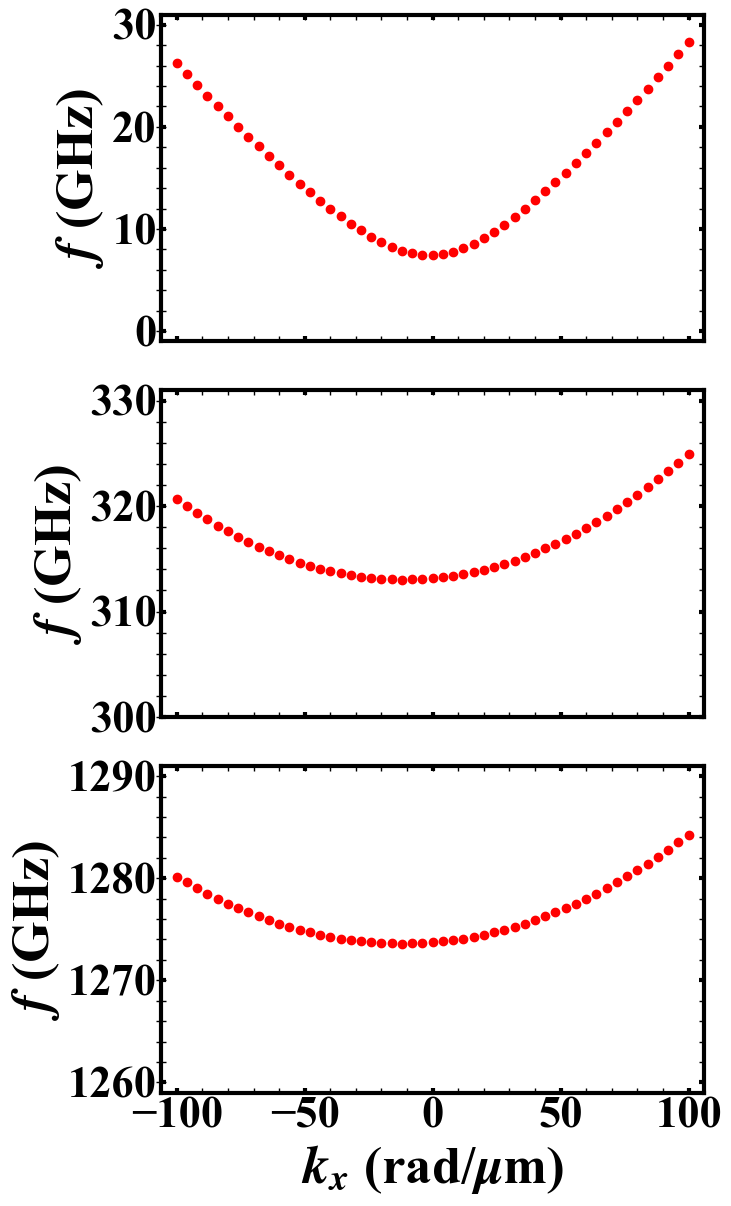

In [7]:
MaxRe_100=(100e6,4)
x=xSWfreqkxM(MaxRe_100)
y0=SWfreqkxM(H_1,A_1,Ms_1,a_1,gamma_1,laynum_10_10,D_1,MaxRe_100,0)
y1=SWfreqkxM(H_1,A_1,Ms_1,a_1,gamma_1,laynum_10_10,D_1,MaxRe_100,1)
y2=SWfreqkxM(H_1,A_1,Ms_1,a_1,gamma_1,laynum_10_10,D_1,MaxRe_100,2)

plt.rcParams["font.weight"] = "bold"
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.it'] = 'STIXGeneral:italic'
plt.rcParams['mathtext.bf'] = 'STIXGeneral:italic:bold'
fig, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True,figsize=(7, 14))
fig.subplots_adjust(hspace=0.15)
#fig.suptitle('Spin waves modes Ir/Fe/Co/Pt',fontsize=20)
ax1.plot(x,y0,'o',color='red', label='n=0',linewidth=1)
ax1.set_ylabel(r'$\mathbf{f}$ (GHz)',weight='bold',fontsize=38)
#ax1.set_xlabel('Normalized $S_x$',fontsize=15)
ax1.set_ylim([-1,31])

ax1.set_yticks([0,10,20,30])
ax1.tick_params(axis='y', right=True,direction='in',width=3,labelsize=32)
sec1 = ax1.secondary_yaxis(location=0)
sec1.set_yticks(np.linspace(0,30,16),labels=None)
sec1.tick_params(axis='y',right=True,direction='in',width=1,labelleft=False)
thd1 = ax1.secondary_yaxis(location='right')
thd1.set_yticks(np.linspace(0,30,16),labels=None)
thd1.tick_params(axis='y',direction='in',width=1,labelright=False)
ax1.tick_params(axis='y',direction='in',labelsize=32)
ax1.set_xticks([-100,-50,0,50,100],labels=None)
ax1.tick_params(axis='x',direction='in', top=True,width=3,labelbottom=False)
sec1 = ax1.secondary_xaxis(location='bottom')
sec1.set_xticks(np.linspace(-100,100,21),labels=None)
sec1.tick_params(axis='x',direction='in',width=1,labelbottom=False)
thd1 = ax1.secondary_xaxis(location='top')
thd1.set_xticks(np.linspace(-100,100,21),labels=None)
thd1.tick_params(axis='x',direction='in',width=1,labeltop=False)

plt.setp(ax1.spines.values(), lw=3)
#ax1.legend(fontsize=15)
ax2.plot(x,y1,'o',color='red', label='n=1',linewidth=1)
#ax2.set_ylabel('Layer index',fontsize=25)
#ax2.set_xlabel('Normalized $S_x$',fontsize=15)
ax2.set_ylim([329,331])
#ax2.set_xlim([0.99865,1.00005])
ax2.set_ylabel(r'$\mathbf{f}$ (GHz)',weight='bold',fontsize=38)

ax2.set_yticks([300,310,320,330])
ax2.tick_params(axis='y', right=True,direction='in',width=3,labelsize=32)
sec2 = ax2.secondary_yaxis(location=0)
sec2.set_yticks(np.linspace(300,330,16),labels=None)
sec2.tick_params(axis='y',right=True,direction='in',width=1,labelleft=False)
thd2 = ax2.secondary_yaxis(location='right')
thd2.set_yticks(np.linspace(300,330,16),labels=None)
thd2.tick_params(axis='y',width=1,direction='in',labelright=False)
ax2.tick_params(axis='y',direction='in',labelsize=32)
ax2.set_xticks([-100,-50,0,50,100],labels=None)
ax2.tick_params(axis='x', direction='in',top=True,width=3,labelbottom=False)
sec2 = ax2.secondary_xaxis(location='bottom')
sec2.set_xticks(np.linspace(-100,100,21),labels=None)
sec2.tick_params(axis='x',direction='in',width=1,labelbottom=False)
thd2 = ax2.secondary_xaxis(location='top')
thd2.set_xticks(np.linspace(-100,100,21),labels=None)
thd2.tick_params(axis='x',direction='in',width=1,labeltop=False)

plt.setp(ax2.spines.values(), lw=3)
#ax2.legend(fontsize=15)
ax3.plot(x,y2,'o',color='red',label='n=2',linewidth=1)
#ax3.set_ylabel('Layer index',fontsize=25)
#ax3.set_xlabel('Normalized $S_x$',fontsize=15)

ax3.set_ylim([1259,1291])
ax3.set_xlim([-106,106])

ax3.set_ylabel(r'$\mathbf{f}$ (GHz)',weight='bold',fontsize=38)
ax3.set_xlabel(r'$\mathbf{k_x}$ (rad/$\mathbf{\mu}$m)',weight='bold',fontsize=38)

ax3.set_yticks([1260,1270,1280,1290])
ax3.tick_params(axis='y',direction='in', right=True,width=3,labelsize=32)
sec3 = ax3.secondary_yaxis(location=0)
sec3.set_yticks(np.linspace(1260,1290,16),labels=None)
sec3.tick_params(axis='y',direction='in',right=True,width=1,labelleft=False)
thd3 = ax3.secondary_yaxis(location='right')
thd3.set_yticks(np.linspace(1260,1290,16),labels=None)
thd3.tick_params(axis='y',direction='in',width=1,labelright=False)
ax3.tick_params(axis='y',direction='in',labelsize=32)
ax3.set_xticks([-100,-50,0,50,100])
ax3.tick_params(axis='x',direction='in', top=True,width=3,labelsize=32)
sec3 = ax3.secondary_xaxis(location='bottom')
sec3.set_xticks(np.linspace(-100,100,21),labels=None)
sec3.tick_params(axis='x',direction='in',width=1,labelbottom=False)
thd3 = ax3.secondary_xaxis(location='top')
thd3.set_xticks(np.linspace(-100,100,21),labels=None)
thd3.tick_params(axis='x',direction='in',width=1,labeltop=False)

plt.setp(ax3.spines.values(), lw=3)
#ax2.legend(fontsize=15)
plt.show()

<br>
The corresponding mode profiles through the film thickness are drawn below:

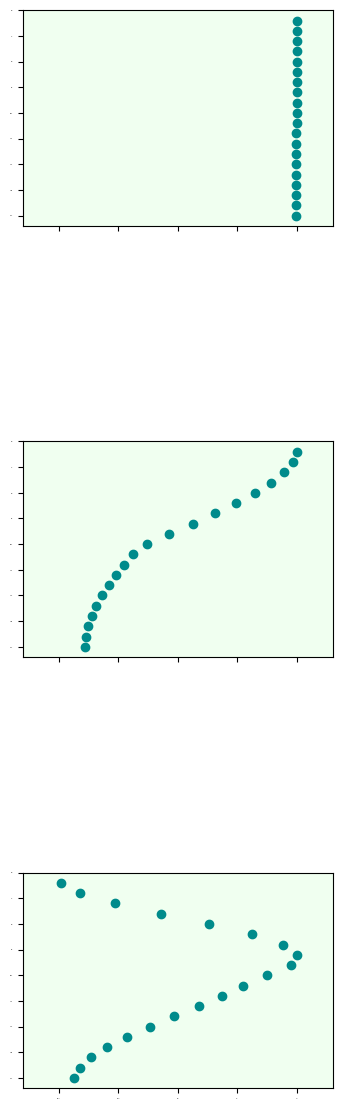

In [5]:
#NModAmpXM(H,A,Ms,a,gamma,laynum,D,k,n)
y=xMobAmpM(laynum_10_10)
x0=NModAmpXM(H_1,A_1,Ms_1,a_1,gamma_1,laynum_10_10,D_1,(50e6,0),0)
x1=NModAmpXM(H_1,A_1,Ms_1,a_1,gamma_1,laynum_10_10,D_1,(50e6,0),1)
x2=NModAmpXM(H_1,A_1,Ms_1,a_1,gamma_1,laynum_10_10,D_1,(50e6,0),2)

fig, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True,figsize=(4, 14))
fig.subplots_adjust(hspace=1)
#fig.suptitle('Spin waves modes Ir/Fe/Co/Pt',fontsize=20)
ax1.plot(x0,y,'o',color='darkcyan', label='n=0',linewidth=1)
#ax1.plot(np.zeros(len(x)), y0,'--',color='black',linewidth=1)
#ax1.set_ylabel('$\Delta f$ (GHz)',fontsize=32)
#ax1.set_xlabel('Normalized $S_x$',fontsize=15)
ax1.set_ylim([21,0])
ax1.set_xlim([-1.1,1.1])
ax1.tick_params(axis='y', labelsize=0)
ax1.tick_params(axis='x', labelsize=0)
ax1.set_facecolor("honeydew")
#ax1.xaxis.set_ticks(np.arange(0.9985, 1.00061, 0.0006))
#ax1.legend(fontsize=15)
ax2.plot(x1,y,'o',color='darkcyan', label='n=1',linewidth=1)
#ax2.set_ylabel('Layer index',fontsize=25)
#ax2.set_xlabel('Normalized $S_x$',fontsize=15)
#ax2.xaxis.set_ticks(np.arange(0.9985, 1.00061, 0.0006))
ax2.set_ylim([21,0])
ax2.set_xlim([-1.1,1.1])
#ax2.set_ylabel('$\Delta f$ (GHz)',fontsize=32)
ax2.tick_params(axis='y',labelsize=0)
ax2.tick_params(axis='x', labelsize=0)
ax2.set_facecolor("honeydew")
#ax2.legend(fontsize=15)
ax3.plot(x2,y,'o',color='darkcyan',label='n=2',linewidth=1)
#ax3.set_ylabel('Layer index',fontsize=25)
#ax3.set_xlabel('Normalized $S_x$',fontsize=15)
#ax2.xaxis.set_ticks(np.arange(0.9985, 1.00061, 0.0006))
ax3.set_ylim([21,0])
ax3.set_xlim([-1.3,1.3])
#ax3.set_ylabel('$\Delta f$ (GHz)',fontsize=32)
ax3.tick_params(axis='y',labelsize=0)
ax3.tick_params(axis='x', labelsize=0)
#ax3.set_xlabel('$k_x$ (rad/$\mu$m)',fontsize=32)
#ax2.legend(fontsize=15)
ax3.set_facecolor("honeydew")
plt.show()